# Data Analysis Interview Challenge, Part 1: Exploratory Data Analysis

<span style="color:navy">
    <b>Instructions</b>: The attached <i>logins.json</i> file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.
</span>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss

First, read the JSON file.

In [3]:
logins_df = pd.read_json(".\data\logins.json")

In [4]:
logins_df.shape

(93142, 1)

In [5]:
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [6]:
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


The timestamps look to be recorded in a 24-hour 'YYYY-MM-DD HH:MM:SS' format.

In [7]:
logins_df.describe(datetime_is_numeric=True)

,login_time
count,93142
mean,1970-02-26 19:09:39.779648278
min,1970-01-01 20:12:16
25%,1970-02-04 10:37:19.750000
50%,1970-03-01 06:33:05.500000
75%,1970-03-22 04:01:10.750000
max,1970-04-13 18:57:38


The min value does not match the time at the first index, so the dataframe will be sorted.

In [8]:
logins_df = logins_df.sort_values('login_time')
logins_df.head(10)

,login_time
6,1970-01-01 20:12:16
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
3,1970-01-01 20:16:36
2,1970-01-01 20:16:37
5,1970-01-01 20:21:41
10,1970-01-01 20:26:05
4,1970-01-01 20:26:21
11,1970-01-01 20:31:03
12,1970-01-01 20:34:46


In [9]:
logins_df.nunique()

login_time    92265
dtype: int64

Although there are 93,142 logins, there are only 92,265 logins, so 877 logins occur at the same time.

## 15-minute Interval Aggregation

In [10]:
max_datetime = logins_df['login_time'].max()
min_datetime = logins_df['login_time'].min()
print("{} = ({}) - ({})".format(max_datetime - min_datetime, max_datetime, min_datetime))

101 days 22:45:22 = (1970-04-13 18:57:38) - (1970-01-01 20:12:16)


In [11]:
# days * hours_per_day * min_per_hour / 15 minutes
102*24*60/15

9792.0

In [12]:
len(pd.date_range(start=min_datetime, end=max_datetime, freq='15T'))

9788

The range is almost 102 days, so in 15 minute increments, the number of rows should equate to a little under 9792, or more precisely to our dataset, we can check using `pd.date_range()`, which resulted in 9788 rows. Next, we can use Pandas's handy [`resample()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html) method.

In [13]:
# Setting origin='start' means that we start grouping the logins into 15-minute increments from the start of our dataset,
# which is our .min(), 1970-01-01 20:12:16.
logins_15m_df = logins_df.resample('15T', on='login_time', origin='start').count()
logins_15m_df.head()

,login_time
login_time,
1970-01-01 20:12:16,8
1970-01-01 20:27:16,8
1970-01-01 20:42:16,6
1970-01-01 20:57:16,3
1970-01-01 21:12:16,3


In [14]:
logins_15m_df.rename(columns={'login_time':'logins_per_15m'}, inplace=True)

In [15]:
logins_15m_df['logins_per_15m'].describe()

count    9788.000000
mean        9.515938
std         8.353281
min         0.000000
25%         3.000000
50%         7.000000
75%        13.000000
max        71.000000
Name: logins_per_15m, dtype: float64

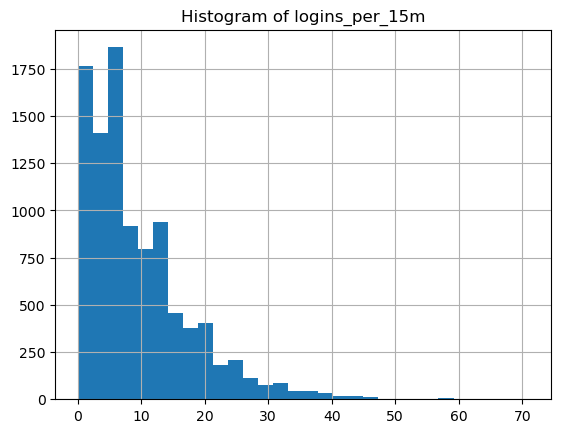

In [70]:
fig, ax = plt.subplots()
logins_15m_df['logins_per_15m'].hist(bins=30, ax=ax)
_ = ax.set_title("Histogram of logins_per_15m")

In [18]:
logins_15m_df['month'] = logins_15m_df.index.month
logins_15m_df['day'] = logins_15m_df.index.day
logins_15m_df['hour'] = logins_15m_df.index.hour
logins_15m_df['dow'] = logins_15m_df.index.day_of_week

In [19]:
logins_15m_df.head()

,logins_per_15m,month,day,hour,dow
login_time,,,,,
1970-01-01 20:12:16,8,1,1,20,3
1970-01-01 20:27:16,8,1,1,20,3
1970-01-01 20:42:16,6,1,1,20,3
1970-01-01 20:57:16,3,1,1,20,3
1970-01-01 21:12:16,3,1,1,21,3


In [20]:
logins_15m_df.tail()

,logins_per_15m,month,day,hour,dow
login_time,,,,,
1970-04-13 17:57:16,4,4,13,17,0
1970-04-13 18:12:16,4,4,13,18,0
1970-04-13 18:27:16,5,4,13,18,0
1970-04-13 18:42:16,7,4,13,18,0
1970-04-13 18:57:16,1,4,13,18,0


## Visualizations

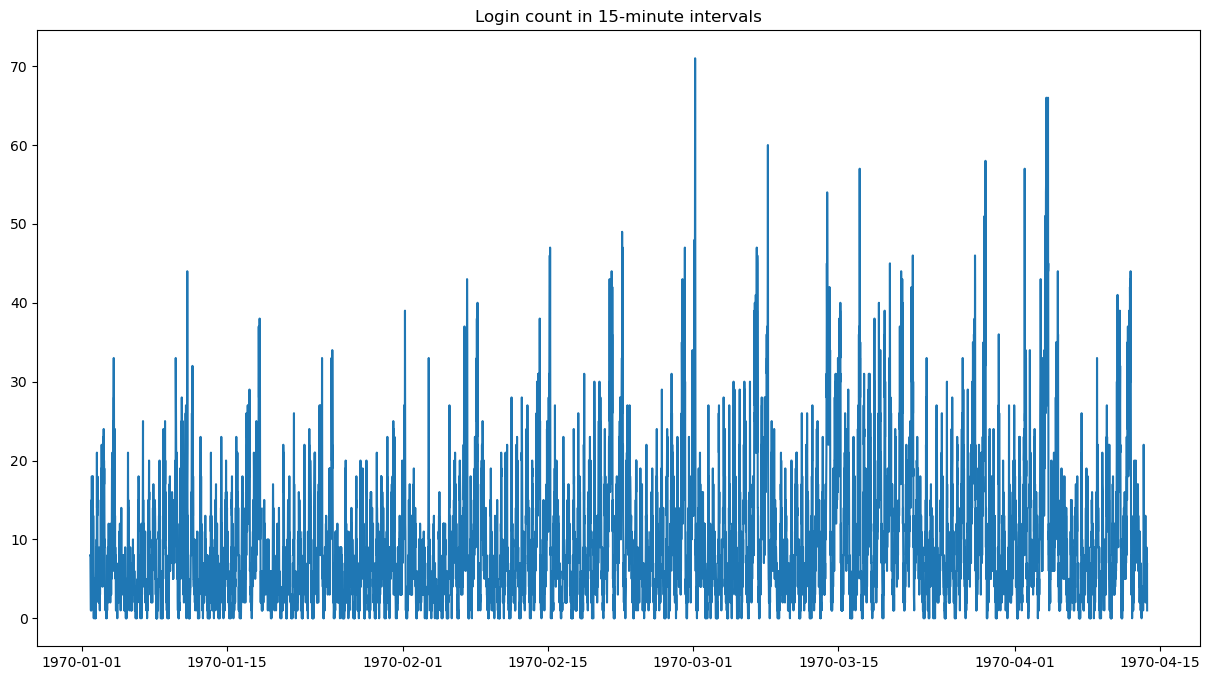

In [68]:
fig, ax = plt.subplots(figsize=(15,8))
_ = plt.plot(logins_15m_df.index, logins_15m_df.logins_per_15m)
_ = ax.set_title("Login count in 15-minute intervals")

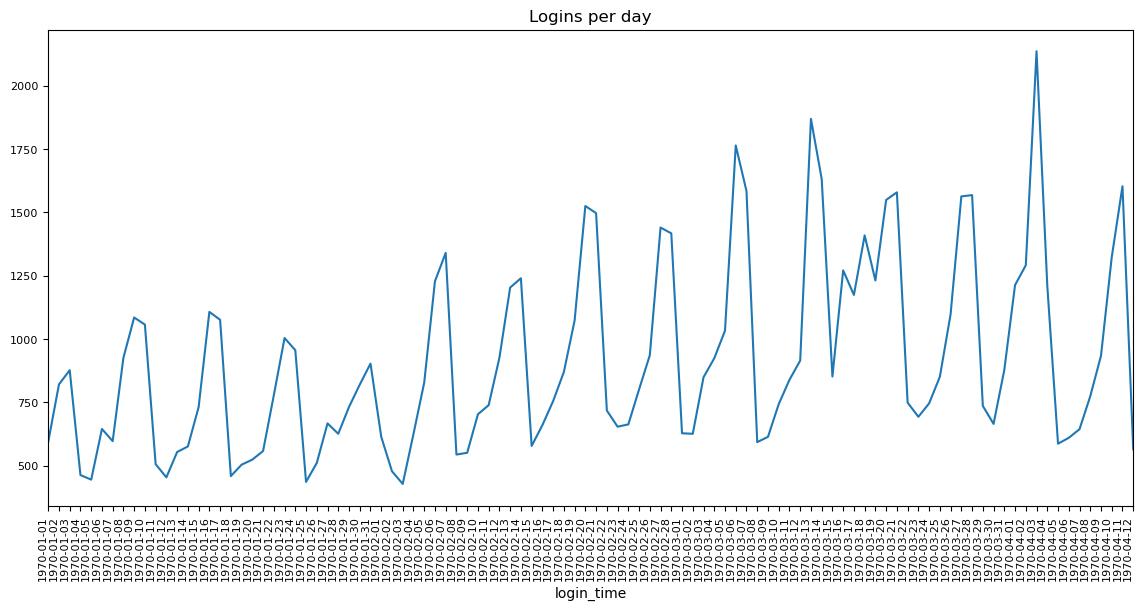

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(14,7))
ax = logins_15m_df['logins_per_15m'].resample('D', origin='start').sum() \
        .plot(kind='line', title='Logins per day',
              xticks=logins_15m_df['logins_per_15m'].resample('D', origin='start').sum().index,
              rot=90,
              xlim=(logins_15m_df['logins_per_15m'].resample('D', origin='start').sum().index.min(),logins_15m_df['logins_per_15m'].resample('D', origin='start').sum().index.max()),
              fontsize=8)

In [25]:
logins_15m_df.groupby('month').sum()['logins_per_15m']

month
1    21250
2    24674
3    33725
4    13493
Name: logins_per_15m, dtype: int64

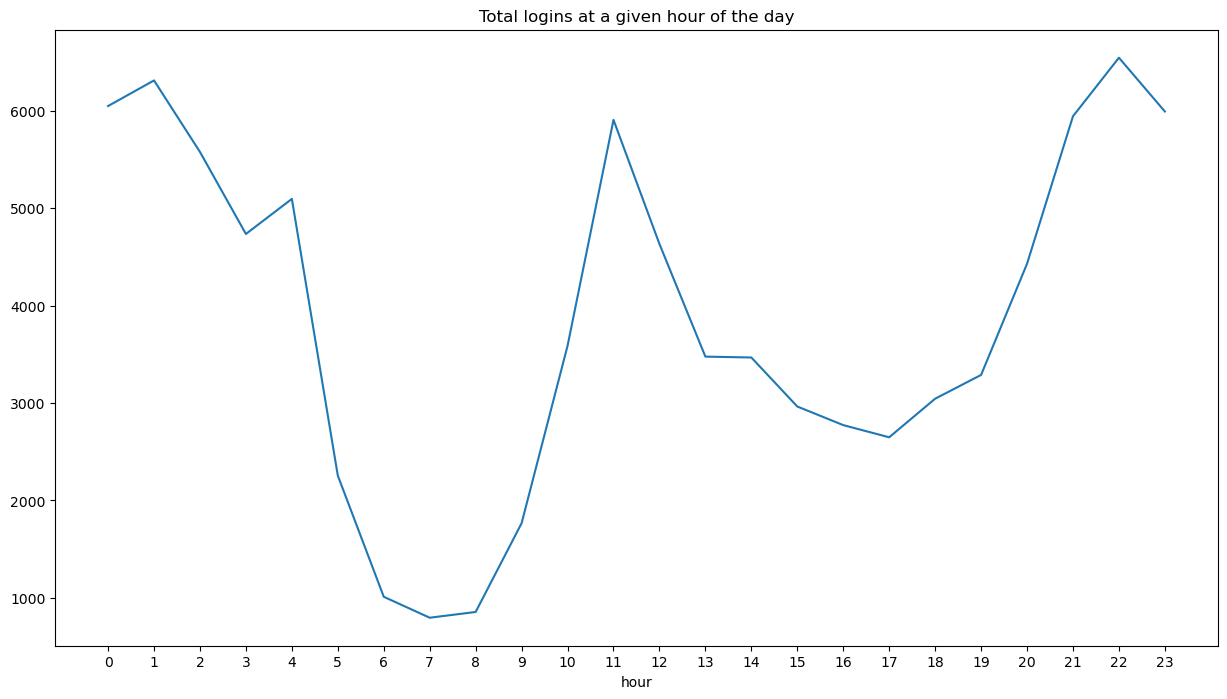

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax = logins_15m_df.groupby('hour').sum()['logins_per_15m'].plot()
_ = ax.set_xticks([h for h in range(0,24)])
_ = ax.set_title("Total logins at a given hour of the day")

For whatever reason, people log in at ridiculous hours of the night and midday, but not so much in the hours of 6-8.

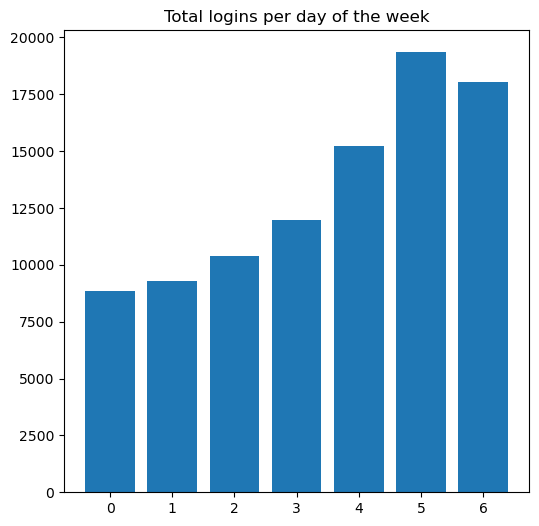

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
_ = ax.bar(logins_15m_df.groupby('dow').sum()['logins_per_15m'].index, logins_15m_df.groupby('dow').sum()['logins_per_15m'].values)
_ = ax.set_title("Total logins per day of the week")
plt.show()

Mondays had the lowest overall number of logins, and Saturday had the most.

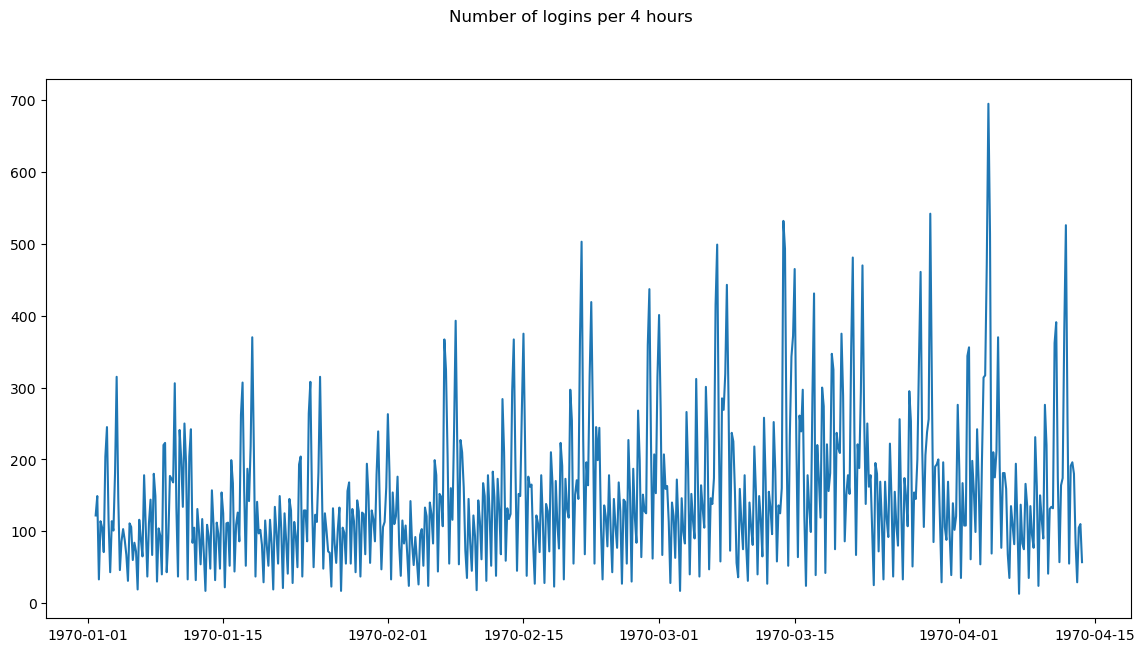

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(14,7))
_ = ax.plot(logins_15m_df[['logins_per_15m']].resample('4H', origin='start').sum().index,
             logins_15m_df[['logins_per_15m']].resample('4H', origin='start').sum())
_ = fig.suptitle("Number of logins per 4 hours")

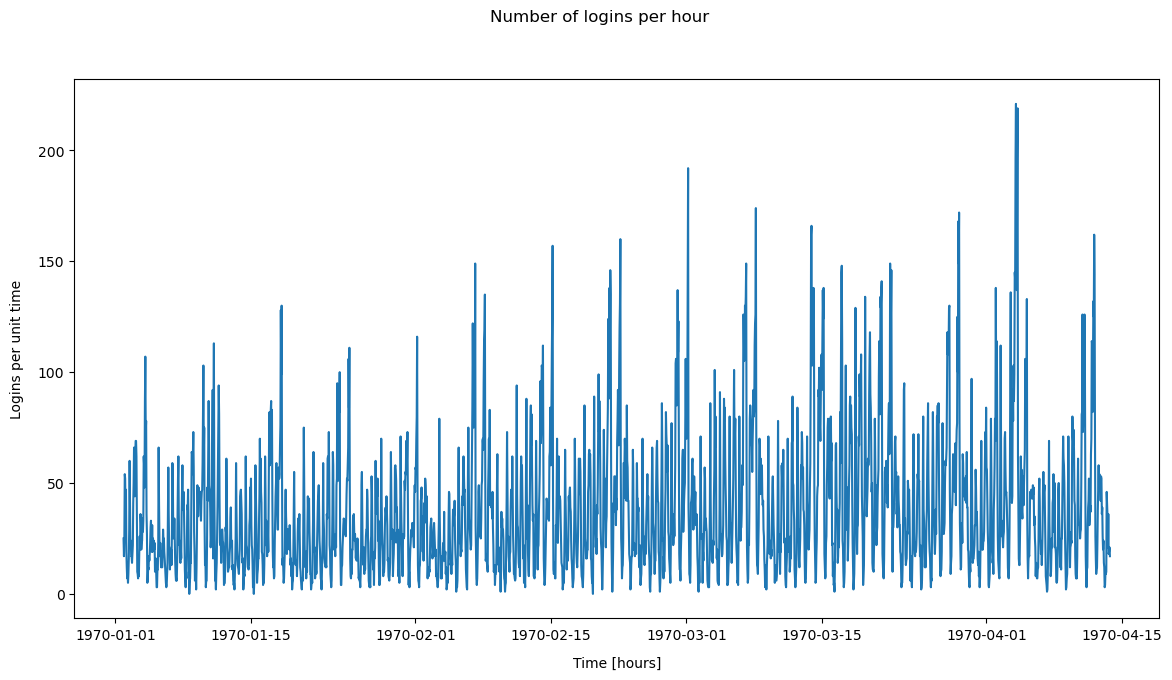

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(14,7))
_ = ax.plot(logins_15m_df[['logins_per_15m']].resample('H', origin='start').sum().index,
             logins_15m_df[['logins_per_15m']].resample('H', origin='start').sum())
_ = ax.set_xlabel("Time [hours]", labelpad=10)
_ = ax.set_ylabel("Logins per unit time", labelpad=10)
_ = fig.suptitle("Number of logins per hour")

The daily and hourly sampled series suggest that there seems to be a seasonality, and the variation of the seasons may be increasing over time. There may be a very gradual increase in logins overall, but it is very slight and may be hard to tell from only 3 months of data.

## Stationarity

We can test stationarity using the Augmented Dickey Fuller (ADF) and Kwiatkowski-Phillip-Schmidt-Shin (KPSS) tests. An example from statsmodels using both tests to determine stationarity can be found [here](https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html).

ADF has the following hypotheses:
- $H_0$: Series is non-stationary, or series has a unit root
- $H_A$: Series is stationary, or series has no unit root

On the other hand, KPSS has the following hypotheses:
- $H_0$: Series is trend stationary, or series has no unit root
- $H_A$: Series is non-stationary, or series has a unit root

By testing both, we have four outcomes:
- Case 1: Both tests conclude that the series is not stationary - The series is not stationary
- Case 2: Both tests conclude that the series is stationary - The series is stationary
- Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.
- Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.

In [55]:
def adf_test(timeseries):
    """
    Computes the adfuller of the given timeseries and prints out the table of results and a brief interpretation,
    depending on the p-value.
    timeseries : The time series to test with ADF.
    (Code adapted from statsmodels example link above.)
    """
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    p_value = dfoutput['p-value']
    print(f'Result: The p-value may indicate that the series is {"" if p_value < 0.05 else "not "}stationary.')

def kpss_test(timeseries):
    """
    Computes the kpss of the timeseries and prints out the table of results and a brief interpretation,
    depending on the p-value.
    timeseries : The time series to test with KPSS.
    (Code adapted from statsmodels example link above.)
    """
    kpsstest = kpss(timeseries, regression='c', nlags='auto')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic', 'p-value', '#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print(kpss_output)
    p_value = kpss_output['p-value']
    print(f'Result: The p-value may indicate that the series is {"not " if p_value < 0.05 else ""}stationary.')

In [56]:
adf_test(logins_15m_df['logins_per_15m'])

Test Statistic                -1.042342e+01
p-value                        1.681539e-18
#Lags Used                     3.800000e+01
Number of Observations Used    9.749000e+03
Critical Value (1%)           -3.431021e+00
Critical Value (5%)           -2.861837e+00
Critical Value (10%)          -2.566928e+00
dtype: float64
Result: The p-value may indicate that the series is stationary.


In [57]:
kpss_test(logins_15m_df['logins_per_15m'])

Test Statistic            2.686707
p-value                   0.010000
#Lags Used               55.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Result: The p-value may indicate that the series is not stationary.


C:\Users\chian\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


- ADF found (test_statistic<crit_value) and (p_value<0.05), so reject null (non-stationary, has unit root). It is stationary or has no unit root.
- KPSS found (test_statistic>crit_value) and (p_value<0.05), so reject null (stationary, has no unit root). It is non-stationary or has a unit root.

The timeseries fell into Case 4, so we can difference the series and then check for stationarity again.

<AxesSubplot:xlabel='login_time'>

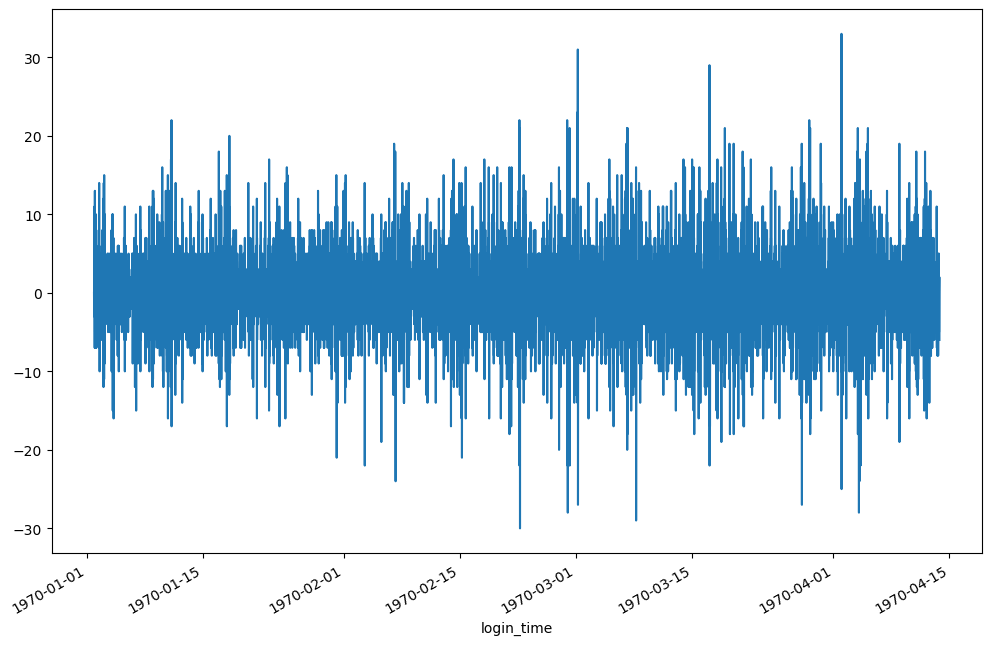

In [58]:
logins_15m_df['logins_per_15m_diff'] = logins_15m_df['logins_per_15m'] - logins_15m_df['logins_per_15m'].shift(1)
logins_15m_df['logins_per_15m_diff'].dropna().plot(figsize=(12,8))

In [59]:
adf_test(logins_15m_df['logins_per_15m_diff'].dropna())

Test Statistic                  -29.418070
p-value                           0.000000
#Lags Used                       37.000000
Number of Observations Used    9749.000000
Critical Value (1%)              -3.431021
Critical Value (5%)              -2.861837
Critical Value (10%)             -2.566928
dtype: float64
Result: The p-value may indicate that the series is stationary.


In [60]:
kpss_test(logins_15m_df['logins_per_15m_diff'].dropna())

Test Statistic            0.005029
p-value                   0.100000
#Lags Used               56.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Result: The p-value may indicate that the series is stationary.


C:\Users\chian\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


- ADF rejected null, so it is stationary or has no unit root.
- KPSS fails to reject null, so it is stationary or has no unit root.